In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from scipy.signal import savgol_filter
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.express as px
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf  # 自相关函数（可选）
from datetime import datetime
from sklearn.ensemble import IsolationForest
from glob import glob
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 处理文件列不匹配问题

In [2]:
files1 = glob("../datas/LA6 MP SPK LG/LG-A/LG-A-S4/*.csv")

In [5]:
def clean_csv(input_path, output_path=None, encoding='utf-8'):
    cleaned_lines = []
    # 读取并清理每一行
    with open(input_path, 'r', encoding=encoding) as f:
        for line in f:
            # 去除行尾换行符和多余逗号（包括连续逗号）
            cleaned_line = line.rstrip('\n')[:-2]
            cleaned_lines.append(cleaned_line)

    # 写入清理后的文件（可选）
    if output_path:
        with open(output_path, 'w', encoding='utf8') as f:
            f.write('\n'.join(cleaned_lines))

In [ ]:
for file in files1:
    _ = clean_csv(file, output_path=os.path.join("../datas/LA6 MP SPK LG/LG-A-new/LG-A-S4/", os.path.basename(file)), encoding='gbk')

In [2]:
files1 = glob("../datas/LA6 MP SPK LG/LG-A-new/LG-A-S4/*.csv")

In [47]:
# df = [pd.read_csv(file, encoding='utf8', on_bad_lines='skip') for file in files1]

# df_use = pd.concat(df, ignore_index=True).set_index('Time')

df_use = pd.read_excel("../datas/合并LG-S4.xlsx", engine='openpyxl', header=0, index_col=0, parse_dates=True)
df_use.columns = [col.lower() for col in df_use.columns]
df_use.index = pd.to_datetime(df_use.index, format='%Y-%m-%d %H:%M:%S %f', errors='coerce')
df_use = df_use[df_use['4_halfatlasresult'].notna() & df_use['2_fullatlasresult'].notna() & df_use['1_fullatlasresult'].notna() & df_use['4_fullatlasresult'].notna()]

In [48]:
df_use

,hsgsn,spk_sn,board_sn,mode,4_halfatlasresult,2_fullatlasresult,1_fullatlasresult,4_fullatlasresult,s2s3installptid,s2s3assystation,...,kc screw 1_full finalangle,kc screw 1_full prevailingtorquemax,kc screw 1_full prevailingtorquemaxangle,kc screw 1_full realangle,kc screw 1_full torqueat630,kc screw 1_full prev torque retest logic,spk screw 4_full finaltorque,spk screw 4_full finalangle,spk screw 4_full totalangle,spk screw 4_full prev torque retest logic
Time,,,,,,,,,,,,,,,,,,,,,
2025-07-03 15:48:55.171,F9WH51174660000JXR,CTHHFK413620000HE6+5BNL83MGXBA,JS-LA5-HM13-L03-LEAD-C1-015,4-2-1-4,OK,OK,OK,OK,S2-2,2.0,...,1160.46,0.06735,-46.98,1434.78,0.05495,0,0.36795,32.94,869.94,0
2025-07-03 16:07:59.716,F9WH51603400000JXR,CTHHFK413620000HE6+5BNL83MGXBA,JS-LA5-HM13-L03-LEAD-C1-038,4-2-1-4,OK,OK,OK,OK,S3-1,3.0,...,916.92,0.05245,616.14,1191.24,0.04960,0,0.36910,379.62,1016.28,0
2025-07-03 16:10:23.318,F9WH51342910000JXR,CTHHFK413UK0000HE6+5BTR82MGXBA,JS-LA5-HM13-L03-LEAD-C1-035,4-2-1-4,OK,OK,OK,OK,S3-1,3.0,...,928.26,0.03820,580.50,1203.12,0.03340,0,0.36795,700.38,1089.72,0
2025-07-03 16:10:56.141,F9WH51620100000JXR,CTHHFK414DZ0000HE6+5A6H81MGXBA,JS-LA5-HM13-L03-LEAD-C1-006,4-2-1-4,OK,OK,OK,OK,S3-1,3.0,...,1018.98,0.04810,553.50,1292.76,0.03850,0,0.36810,610.74,1118.34,0
2025-07-03 16:12:17.460,F9WH51240470000JXR,CTHHFK412RN0000HE6+5BXN82MGXBA,JS-LA5-HM13-L03-LEAD-C1-024,4-2-1-4,OK,OK,OK,OK,S2-1,2.0,...,973.62,0.08405,327.78,1247.94,0.06765,0,0.36815,31.32,996.84,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28 14:00:59.746,H3HHJP00A5Z0000X44,DTVHJJB2AWA0000HE6+A206H2MGEDP,JS-LA5-HM13-L03-LEAD-C1-001,4-2-1-4,OK,OK,OK,OK,S2-2,2.0,...,746.82,0.11885,474.12,1020.60,0.07565,0,0.36785,52.38,793.26,0
2025-07-28 14:01:25.662,H3HHJS001AX0000X44,DTVHJJB11WP0000HE6+A347H1MGEDP,JS-LA5-HM13-L03-LEAD-C1-037,4-2-1-4,OK,OK,OK,OK,S2-1,2.0,...,780.84,0.12445,598.32,1055.70,0.12275,0,0.36795,50.22,859.68,0
2025-07-28 14:01:52.157,H3HHJS0026J0000X44,DTVHJJB13MZ0000HE6+A547B1MGEBP,JS-LA5-HM13-L03-LEAD-C1-032,4-2-1-4,OK,OK,OK,OK,S2-2,2.0,...,1002.24,0.11805,154.98,1276.02,0.08615,0,0.36795,57.78,939.60,0


In [ ]:
df_plot = df_use.copy().iloc[:, 18:43]

torque_cols = [col for col in df_plot.columns if 'Torque' in col and 'Angle' not in col]
angle_cols = [col for col in df_plot.columns if 'Angle' in col]

In [13]:
def plot_torque_angle(df_plot, cols):
    # 合并所有需要绘制的列（先torque后angle）
    total_plots = len(cols)
    
    # 自动计算子图布局（每行最多4列，可根据需求调整）
    ncols = min(2, total_plots)  # 每行最多4列，避免过宽
    nrows = (total_plots + ncols - 1) // ncols  # 向上取整计算行数
    
    # 创建画布和子图（调整figsize适应数量）
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*3))
    axes = axes.flatten()  # 展平为一维数组方便遍历
    
    # 遍历每一列绘制折线图
    for i, col in enumerate(cols):
        ax = axes[i]
        # 绘制当前列（x轴为DataFrame索引，若需指定其他列替换x参数）
        ax.plot(df_plot[col], linewidth=1.5)
        
        # 设置子图标题和坐标轴标签
        ax.set_title(f'{col} Trend', fontsize=10, pad=8)  # 标题居中且紧凑
        ax.set_xlabel('Time Index', fontsize=8)  # 假设x轴是时间索引，可替换为实际列名
        ax.set_ylabel(col.split('_')[0].capitalize(), fontsize=8)  # 自动推断单位（示例逻辑）
        
        # 优化刻度标签（避免重叠）
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(alpha=0.2)  # 浅灰色网格辅助观察
    
    # 隐藏多余的空白子图（如果有）
    # for j in range(i+1, nrows*ncols):
    #     axes[j].axis('off')
    
    # 调整整体布局并显示
    plt.tight_layout()
    plt.show()

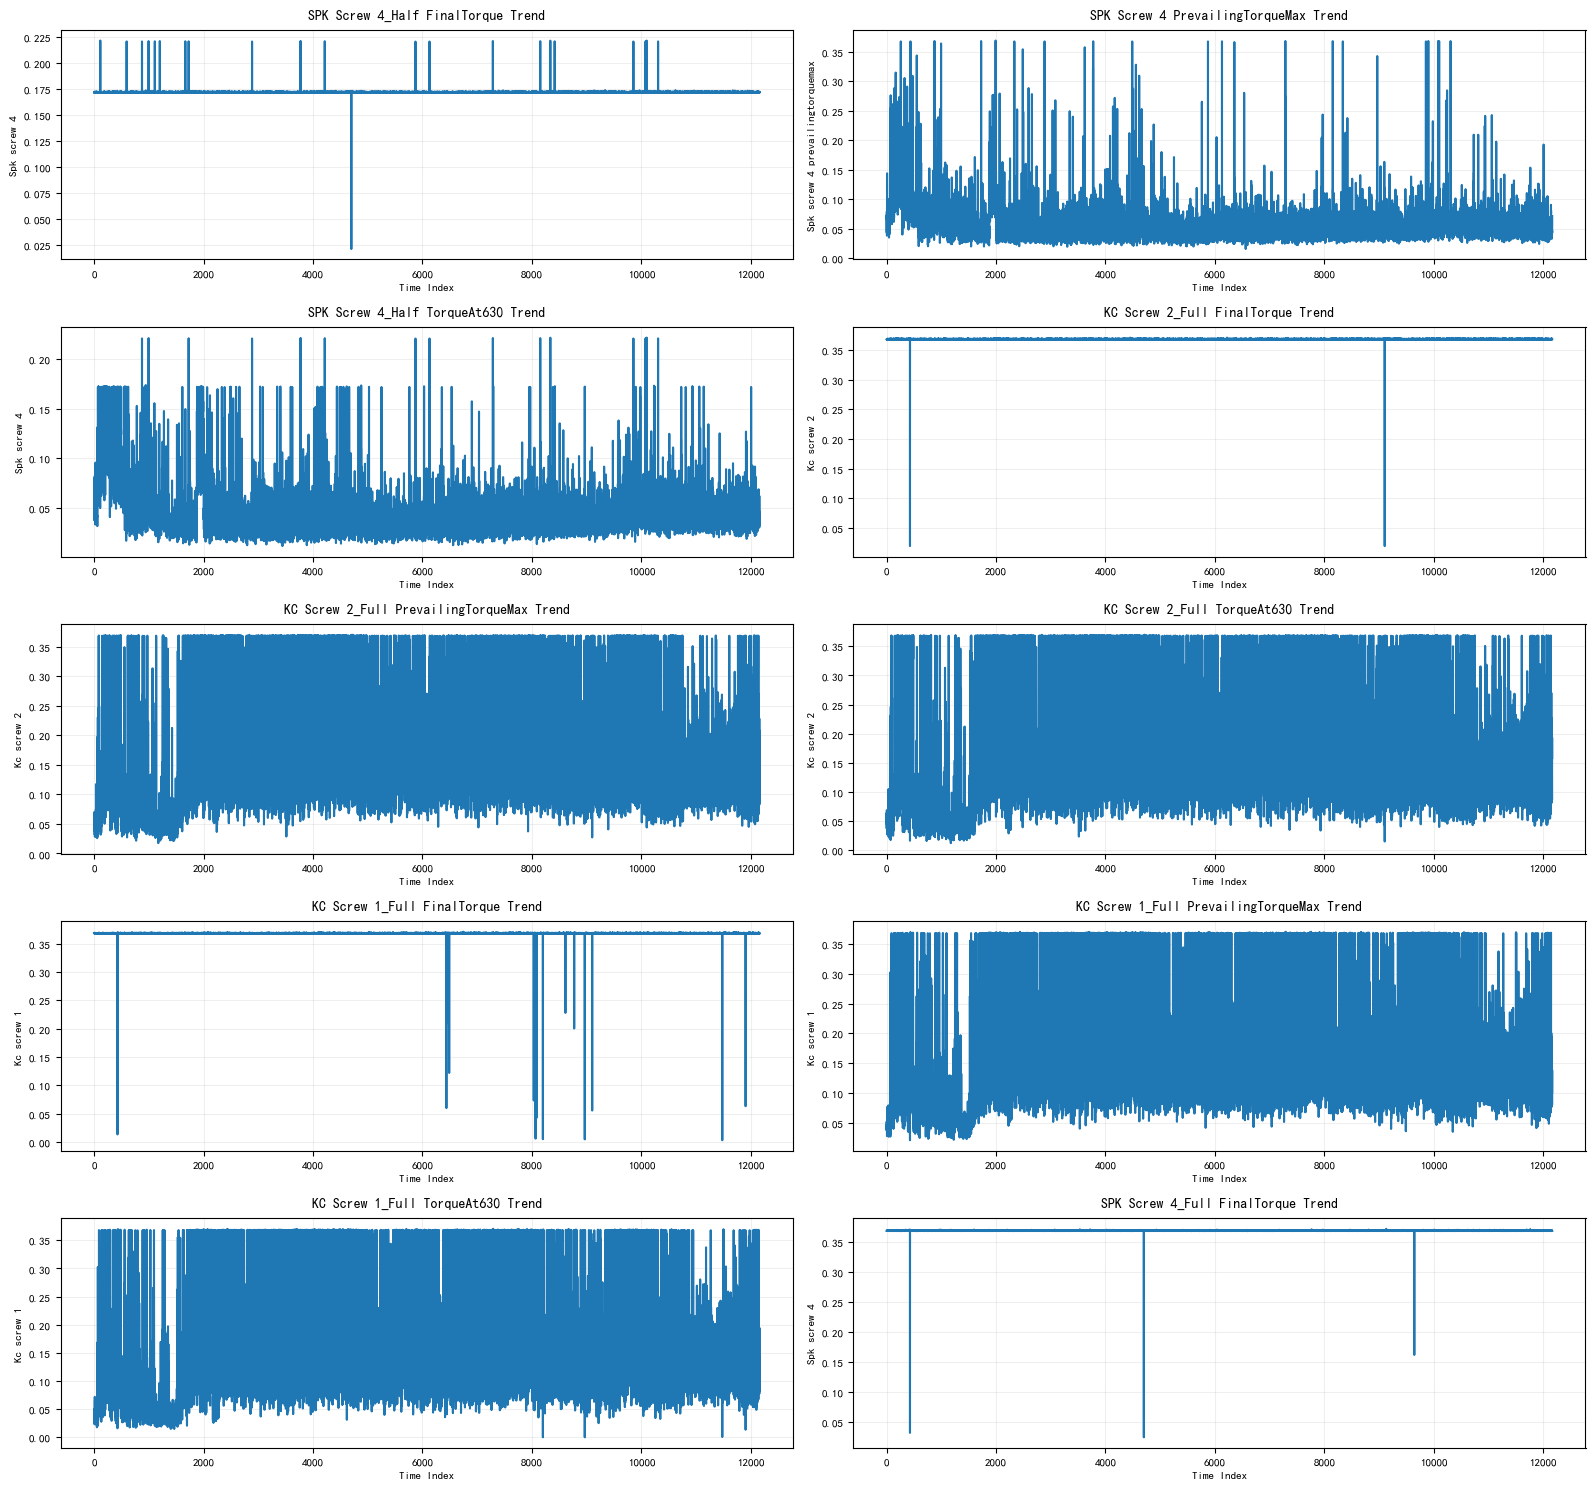

In [14]:
plot_torque_angle(df_plot, torque_cols)

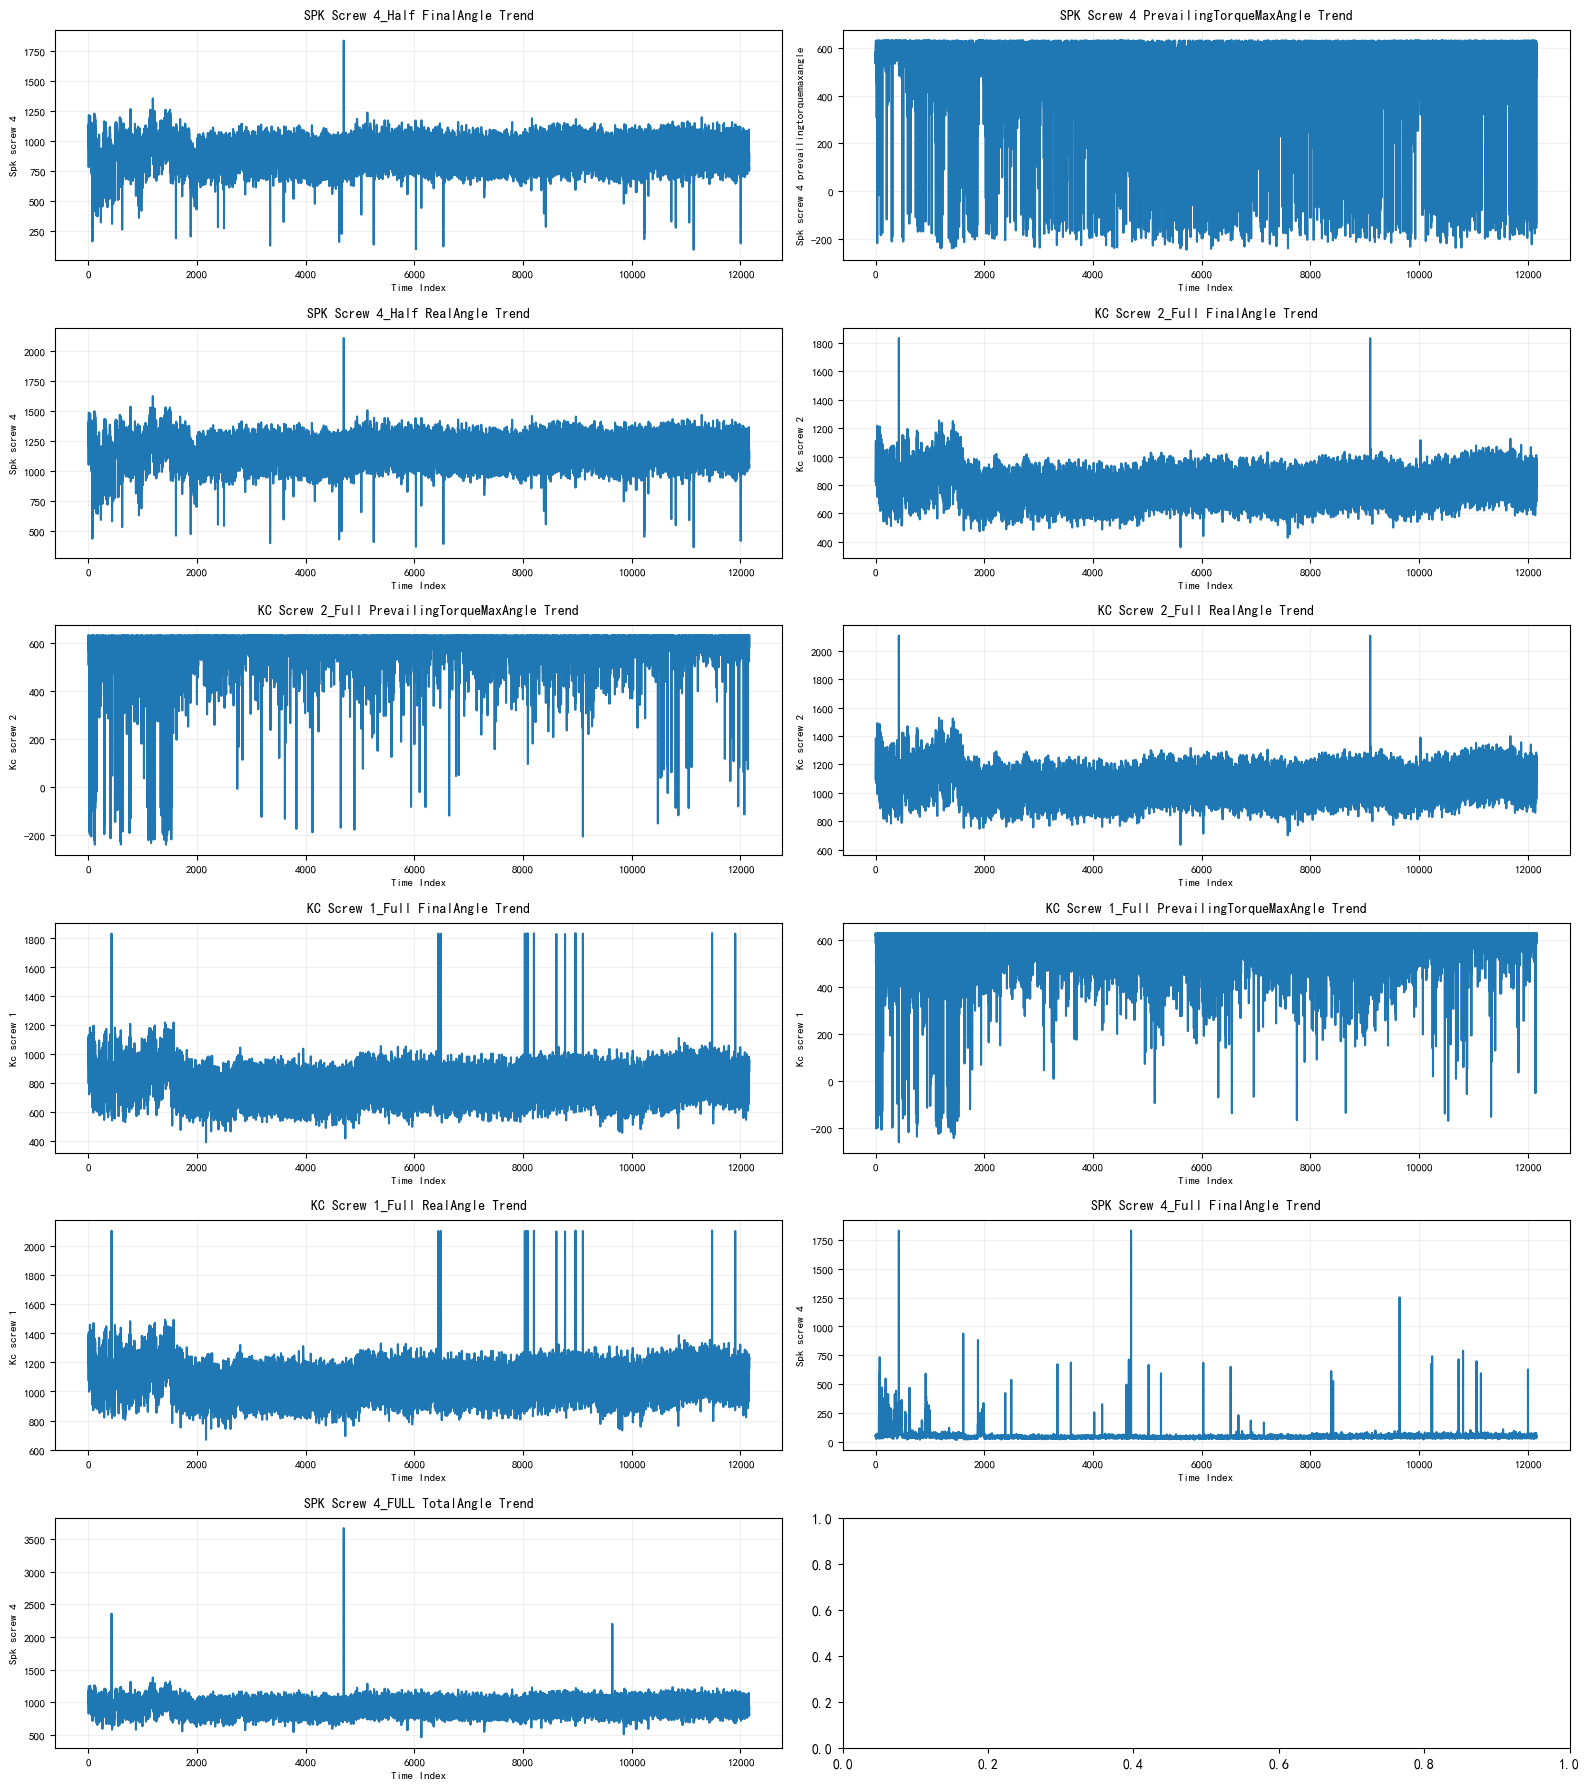

In [15]:
plot_torque_angle(df_plot, angle_cols)

# 2. 预处理

## 2.1 滑动平均

In [5]:
# 定义滑动窗口大小（根据数据频率调整，如500个时间点为一个窗口）
def getMove(df, window_size=100):
    # ==================== 2. 特征工程 - 时序统计特征 ====================
    # 生成移动统计特征
    features = []
    for col in df.columns:
        # 移动平均（去噪）
        df[f'{col}_ma'] = df[col].rolling(window=window_size, min_periods=1).mean()
        # 移动标准差（检测波动）
        df[f'{col}_std'] = df[col].rolling(window=window_size, min_periods=1).std()
        # 一阶差分（检测突变）
        df[f'{col}_diff'] = df[col].diff().abs()
        features.extend([f'{col}_ma', f'{col}_std', f'{col}_diff'])

    # 添加原始特征（可选，根据数据量调整）
    features = list(set(df.columns.tolist() + features))

    # 标准化特征（消除量纲影响）
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])
    df_scaled = pd.DataFrame(df_scaled, columns=features, index=df.index)
    return df_scaled, features

df_scaled, features = getMove(df_plot)

In [7]:
# ==================== 3. 异常检测 - 多方法结合 ====================
# 方法1：统计异常检测（IQR法 - 适用于单变量）
def detect_iqr_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# 方法2：孤立森林（适用于多变量）
def detect_isolation_forest(df_scaled, contamination=0.01):
    model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    outliers = model.fit_predict(df_scaled)
    return outliers == -1  # -1表示异常点

# 合并异常检测结果（逻辑或）
outliers_iqr = pd.DataFrame({col: detect_iqr_outliers(df_plot, col) for col in df_plot.columns}, index=df_plot.index)
outliers_iforest = detect_isolation_forest(df_scaled)
df_plot['is_anomaly'] = outliers_iqr.any(axis=1) | outliers_iforest

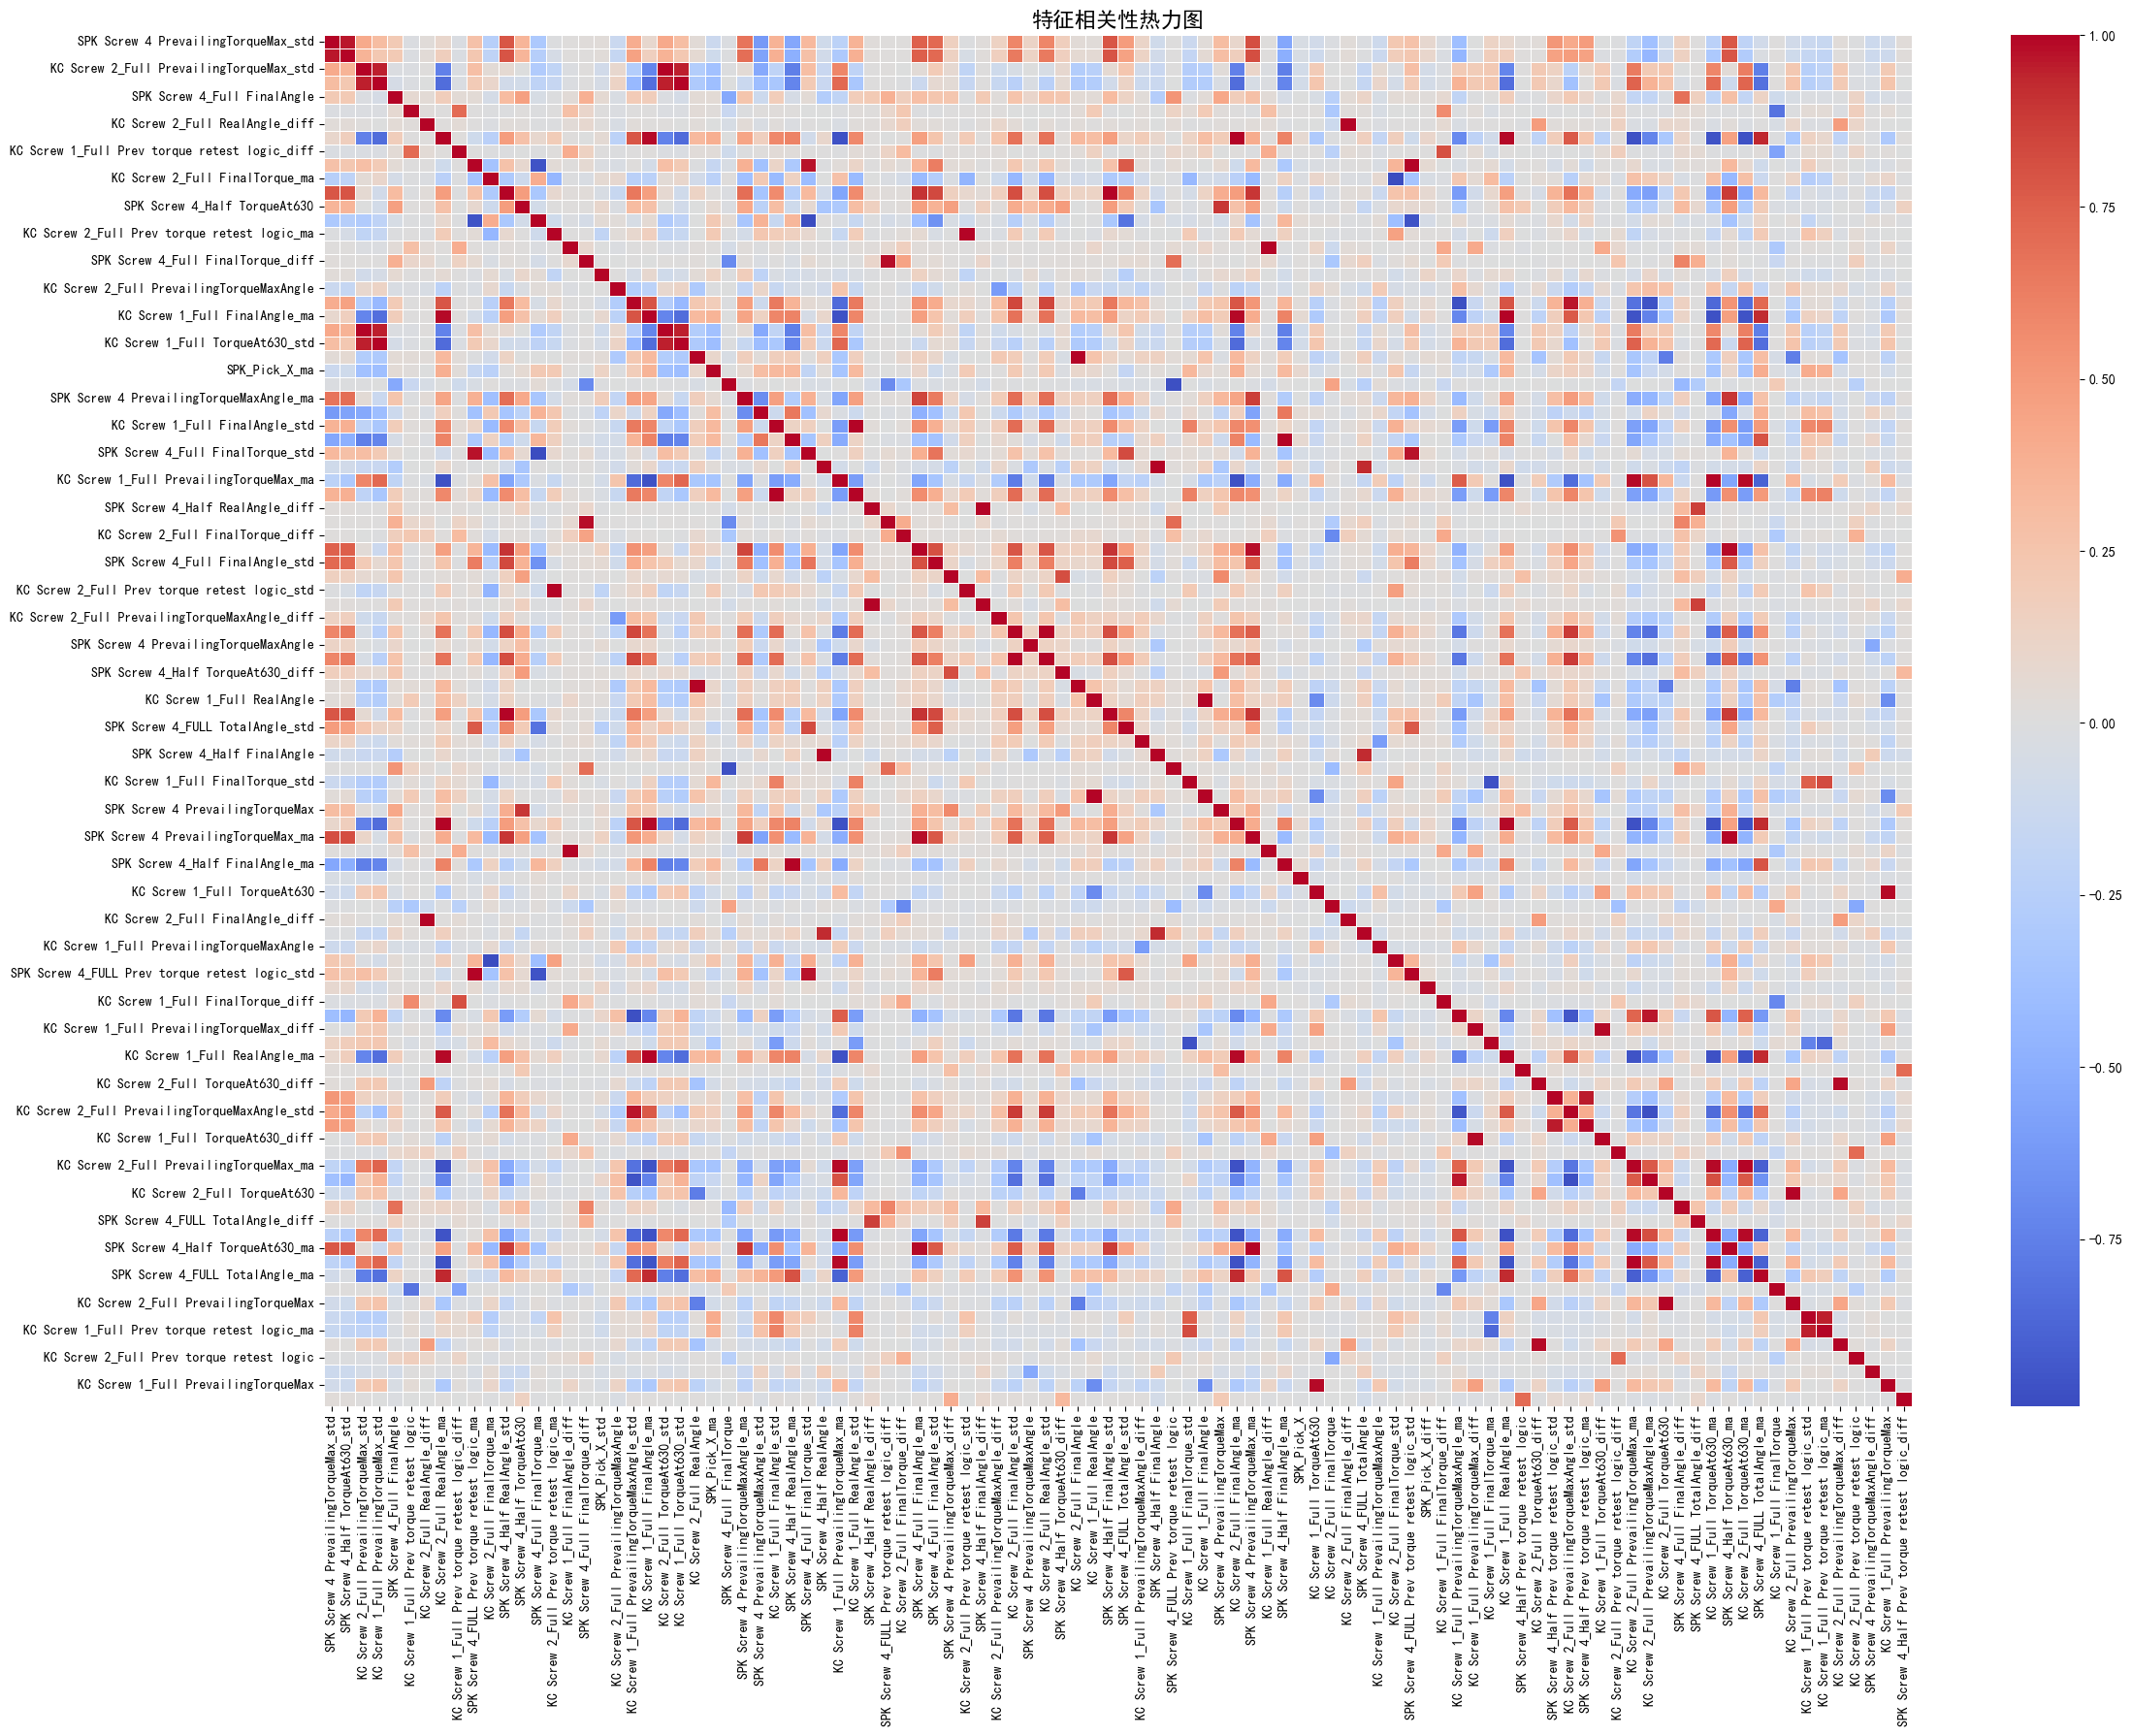

In [8]:
# ==================== 4. 可视化优化方案 ====================
# 4.1 分面热力图 - 特征相关性 + 异常点标注
plt.figure(figsize=(24, 18))
corr_matrix = df_plot[features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("特征相关性热力图", fontsize=16)
plt.xticks()
plt.tight_layout()
plt.show()

In [ ]:
# 4.2 交互式时序图 - 缩放查看密集区域（使用Plotly）
def plot_interactive_timeseries(df, anomalies_df):
    fig = px.line(df, x=df.index, y=df.columns.tolist()[:10],  # 选择前10个特征展示
                  title="交互式时序图（可缩放平移）",
                  labels={'value': '特征值', 'variable': '特征名称'})
    
    # 标记异常点
    anomaly_indices = anomalies_df[anomalies_df['is_anomaly']].index
    for col in df.columns:
        fig.add_scatter(x=anomaly_indices, y=df.loc[anomaly_indices, col], mode='markers', name='异常点', marker=dict(color='red', size=3))
    
    fig.update_layout(hovermode='x unified')
    fig.show()

plot_interactive_timeseries(df_plot, df_plot[['is_anomaly'] + features])

In [11]:
df_scaled

,SPK Screw 4 PrevailingTorqueMax_std,SPK Screw 4_Half TorqueAt630_std,KC Screw 2_Full PrevailingTorqueMax_std,KC Screw 1_Full PrevailingTorqueMax_std,SPK Screw 4_Full FinalAngle,KC Screw 1_Full Prev torque retest logic,KC Screw 2_Full RealAngle_diff,KC Screw 2_Full RealAngle_ma,KC Screw 1_Full Prev torque retest logic_diff,SPK Screw 4_FULL Prev torque retest logic_ma,...,SPK Screw 4_FULL TotalAngle_ma,KC Screw 1_Full FinalTorque,KC Screw 2_Full PrevailingTorqueMax,KC Screw 1_Full Prev torque retest logic_std,KC Screw 1_Full Prev torque retest logic_ma,KC Screw 2_Full PrevailingTorqueMax_diff,KC Screw 2_Full Prev torque retest logic,SPK Screw 4 PrevailingTorqueMaxAngle_diff,KC Screw 1_Full PrevailingTorqueMax,SPK Screw 4_Half Prev torque retest logic_diff
Time,,,,,,,,,,,,,,,,,,,,,
2025-07-03 19:33:16.358,NaN,NaN,NaN,NaN,0.184868,-0.040612,NaN,0.671300,NaN,-0.375268,...,3.390268,0.052796,-1.288591,NaN,-0.765011,NaN,-0.024014,NaN,-1.192982,NaN
2025-07-03 19:34:09.593,-2.377180,-2.306216,-4.313106,-4.624855,0.229961,-0.040612,-0.628597,1.400935,-0.057484,-0.375268,...,3.535820,0.008782,-1.051931,-0.915721,-0.765011,-0.782901,-0.024014,-0.628645,-1.336682,-0.0603
2025-07-03 19:34:35.824,-1.542355,-1.170034,-4.278710,-4.780811,0.015768,-0.040612,0.387262,2.780432,-0.057484,-0.375268,...,3.501165,0.008782,-1.389536,-0.915721,-0.765011,-0.668956,-0.024014,-0.628645,-1.233877,-0.0603
2025-07-03 19:35:30.351,-1.403661,-1.063676,-4.390623,-4.807333,-0.209698,-0.040612,-0.506937,3.046992,-0.057484,-0.375268,...,3.338285,0.082139,-1.122031,-0.915721,-0.765011,-0.748085,-0.024014,-0.661025,-1.322482,-0.0603
2025-07-03 19:36:38.716,-1.260598,-0.820173,-4.373215,-4.838724,0.027042,-0.040612,0.180441,3.809315,-0.057484,-0.375268,...,2.866281,-0.005889,-1.027816,-0.915721,-0.765011,-0.943691,-0.024014,-0.844513,-1.319642,-0.0603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28 13:51:39.783,-0.968234,-0.802637,-0.771097,-0.623592,0.060862,-0.040612,-1.315975,0.541577,-0.057484,-0.375268,...,0.746338,0.062577,-0.677873,0.598219,0.186516,-0.598057,-0.024014,2.868411,-0.446654,-0.0603
2025-07-28 13:52:04.373,-0.969717,-0.809632,-0.768538,-0.627328,0.139775,-0.040612,-0.251452,0.552971,-0.057484,-0.375268,...,0.751162,-0.015670,-0.844993,0.598219,0.186516,-0.861397,-0.024014,-0.731182,-0.639768,-0.0603
2025-07-28 13:52:28.538,-0.973289,-0.809438,-0.766838,-0.627342,-0.164604,-0.040612,2.054002,0.541040,-0.057484,-0.375268,...,0.742013,0.018563,0.355693,0.598219,0.186516,0.305277,-0.024014,-0.310240,-0.435863,-0.0603


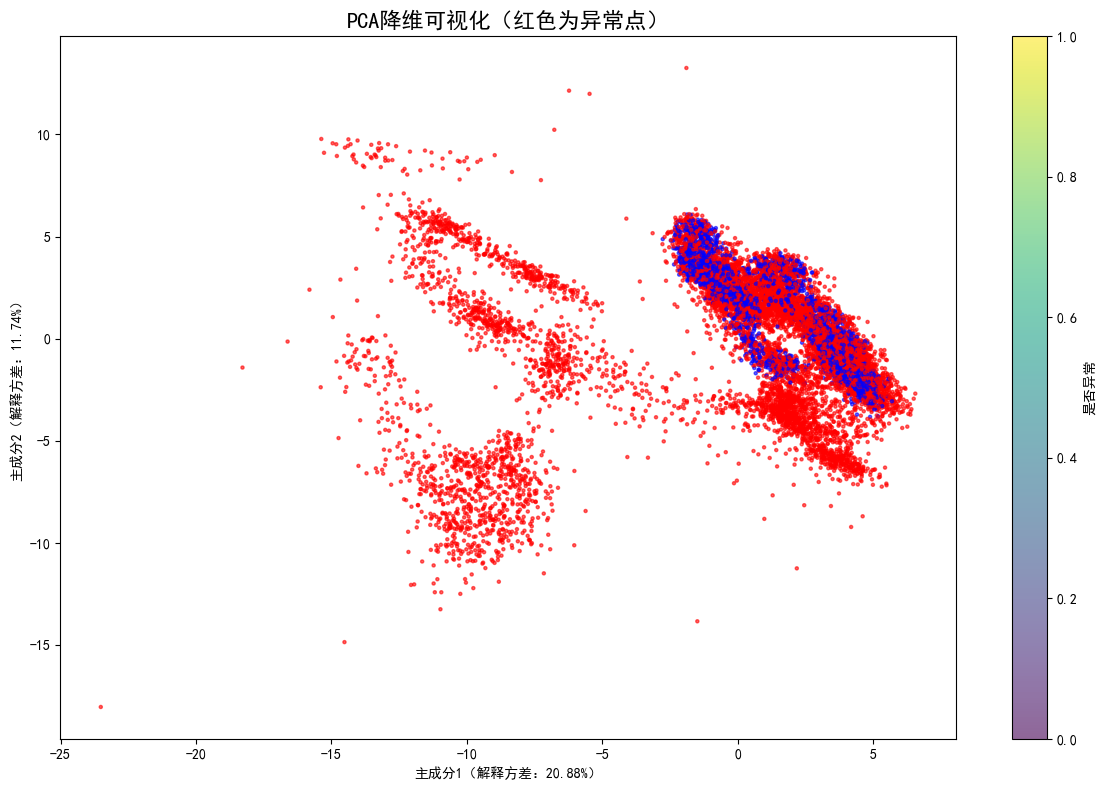

In [13]:
# 4.3 降维聚类可视化 - PCA + 异常点着色
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled.dropna(axis=0))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_plot.dropna(axis=0)['is_anomaly'].map({True: 'red', False: 'blue'}), alpha=0.6, cmap='coolwarm', s=5)
plt.colorbar(scatter, label='是否异常')
plt.title("PCA降维可视化（红色为异常点）", fontsize=16)
plt.xlabel(f"主成分1（解释方差：{pca.explained_variance_ratio_[0]:.2%}）")
plt.ylabel(f"主成分2（解释方差：{pca.explained_variance_ratio_[1]:.2%}）")
plt.tight_layout()
plt.show()

In [18]:
len(df_plot.columns)

101

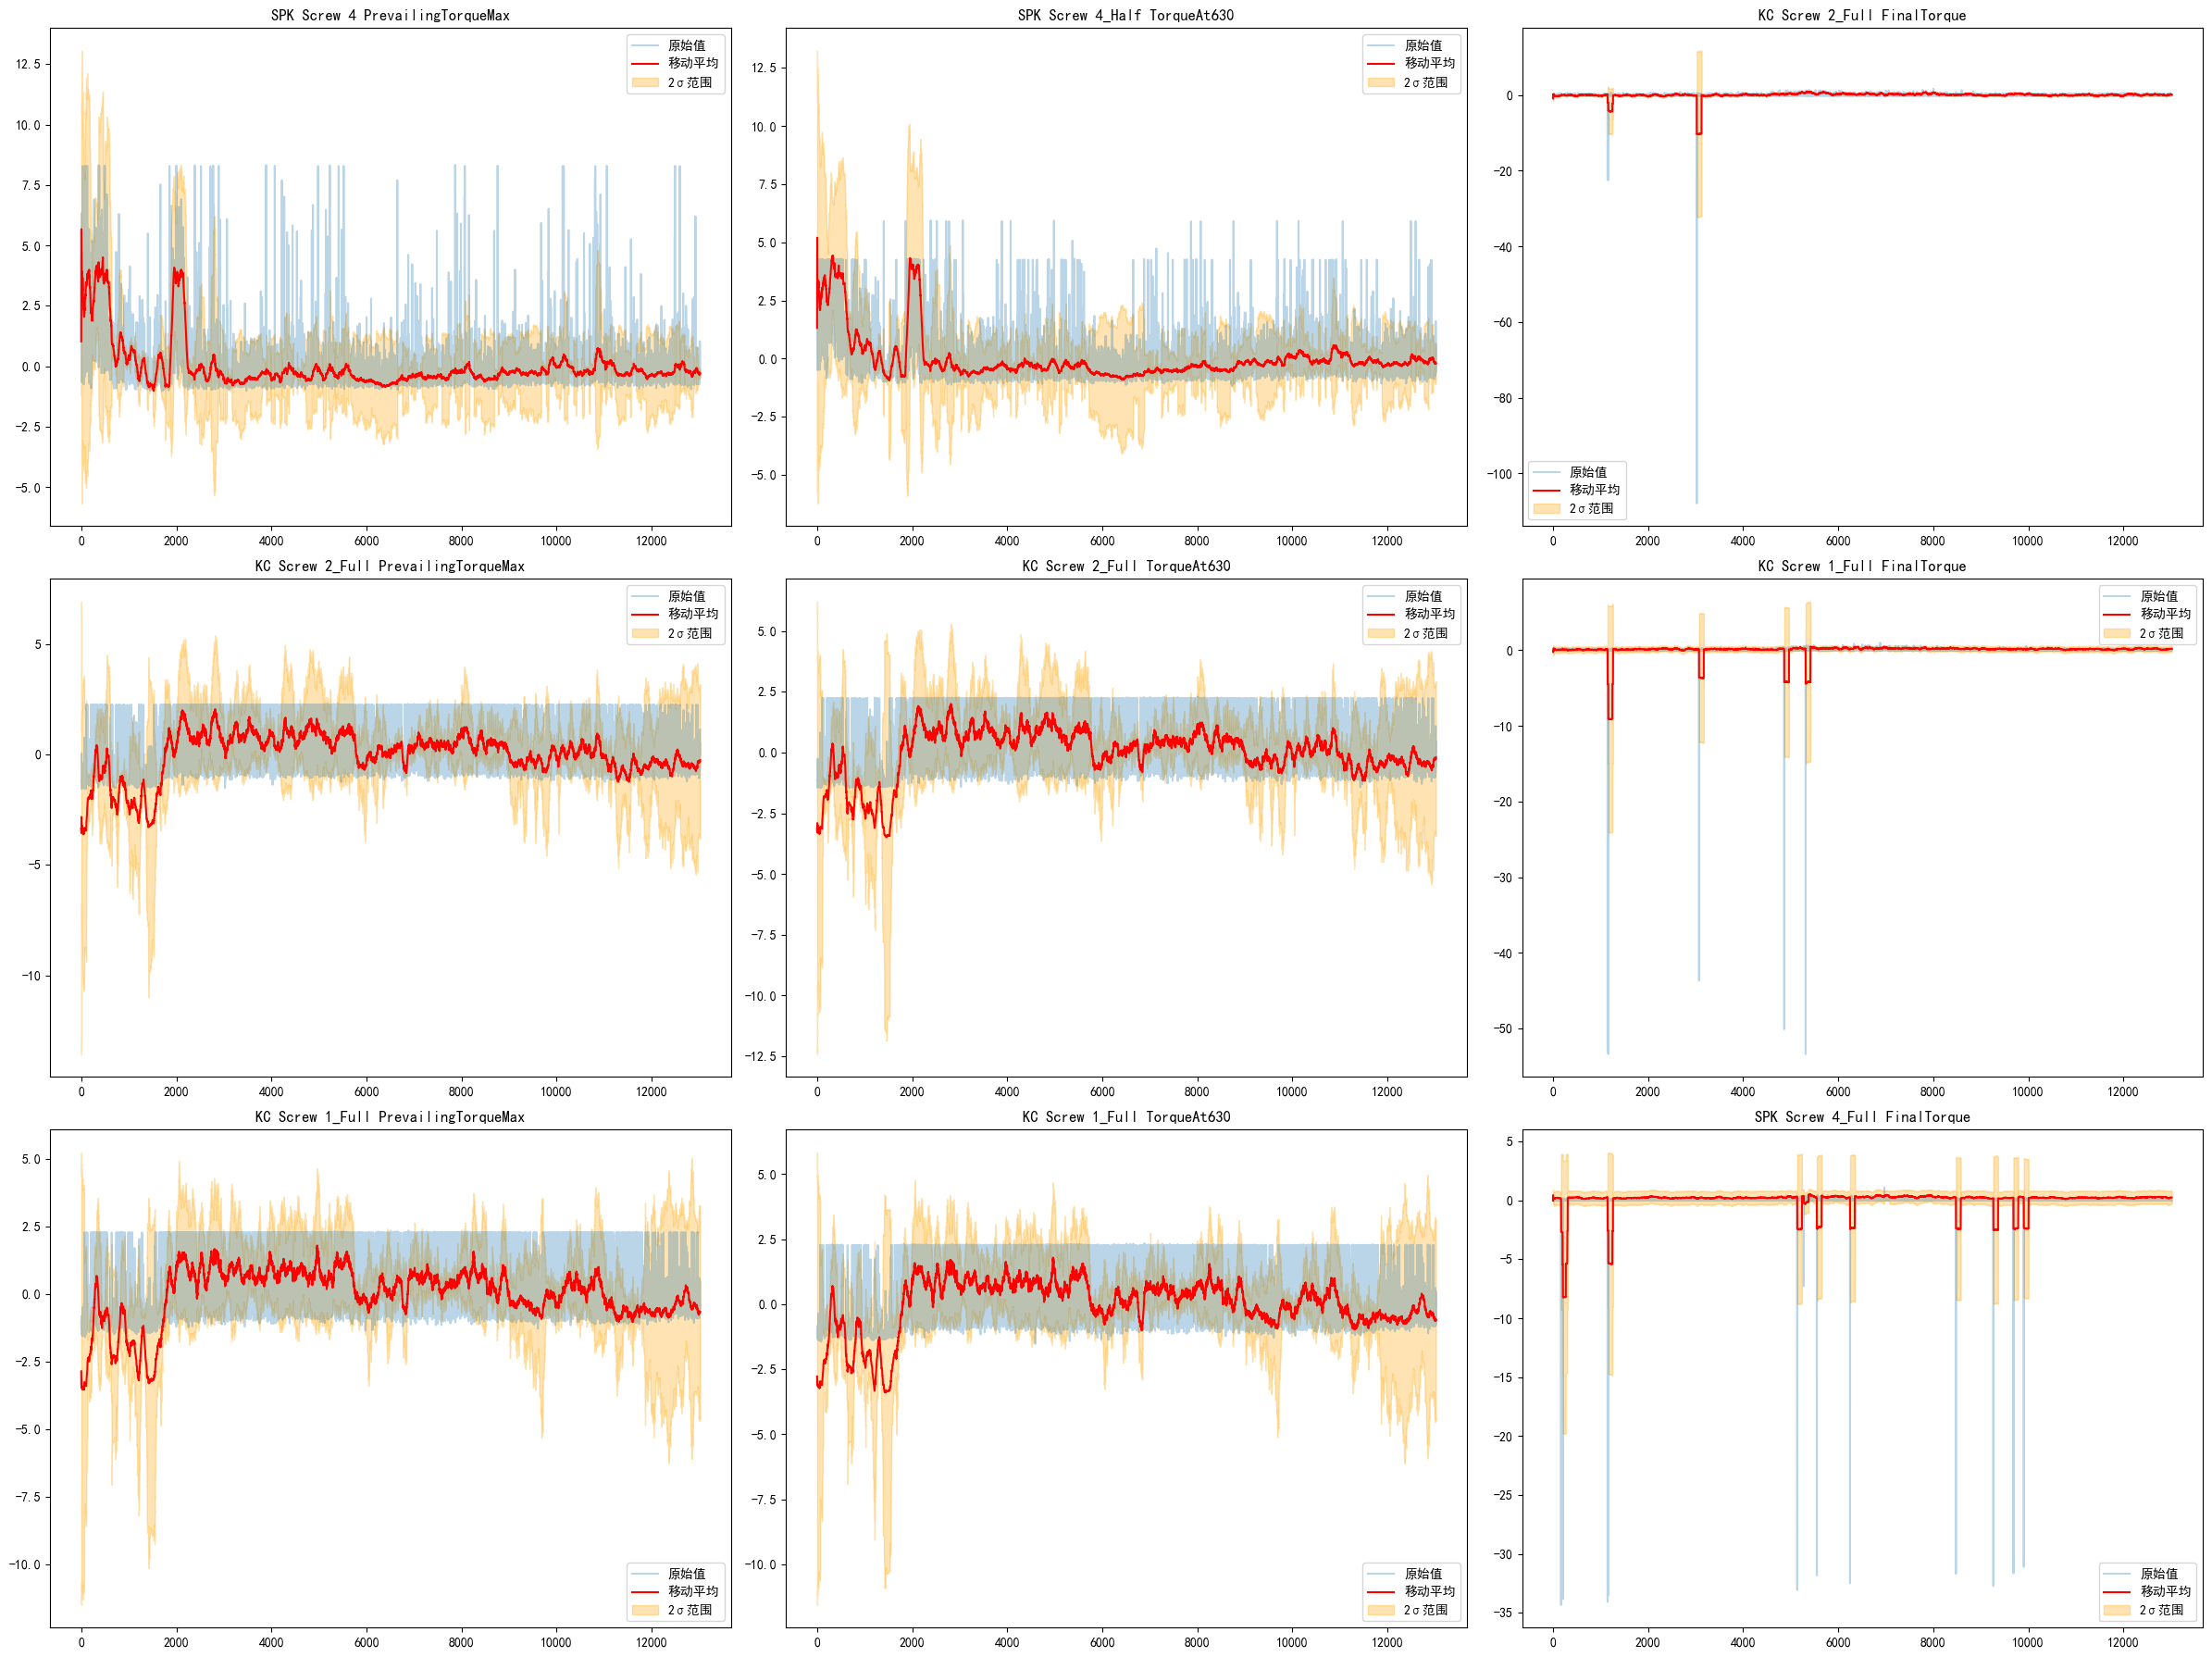

In [40]:
# 4.4 批杆更换候选时间点分析 - 滑动窗口统计量突变
def plotMov(df: pd.DataFrame, cols):

    df_temp = df.copy().reset_index()
    fig, axs = plt.subplots(3, (len(cols) + 2) // 3, figsize=(24, 18))
    axs = axs.flatten()
    for idx, col in enumerate(cols):  # 选择关键特征展示
        ax = axs[idx]
        # 绘制移动平均 + 标准差带
        ax.plot(df_temp.index, df_temp[col], alpha=0.3, label='原始值')
        ax.plot(df_temp.index, df_temp[f'{col}_ma'], color='red', label='移动平均')
        ax.fill_between(df_temp.index, 
                        df_temp[f'{col}_ma'] - 2*df_temp[f'{col}_std'], 
                        df_temp[f'{col}_ma'] + 2*df_temp[f'{col}_std'], 
                        color='orange', alpha=0.3, label='2σ范围')
        # 标记异常点
        # anomaly_points = df_temp.loc[df_temp['is_anomaly'], col]
        # if not anomaly_points.empty:
        #     ax.scatter(anomaly_points.index, anomaly_points, color='green', zorder=3, label='检测异常')
        ax.set_title(f"{col}", fontsize=12)
        ax.legend()
    plt.tight_layout()
    plt.show()

plotMov(df_scaled, torque_cols)

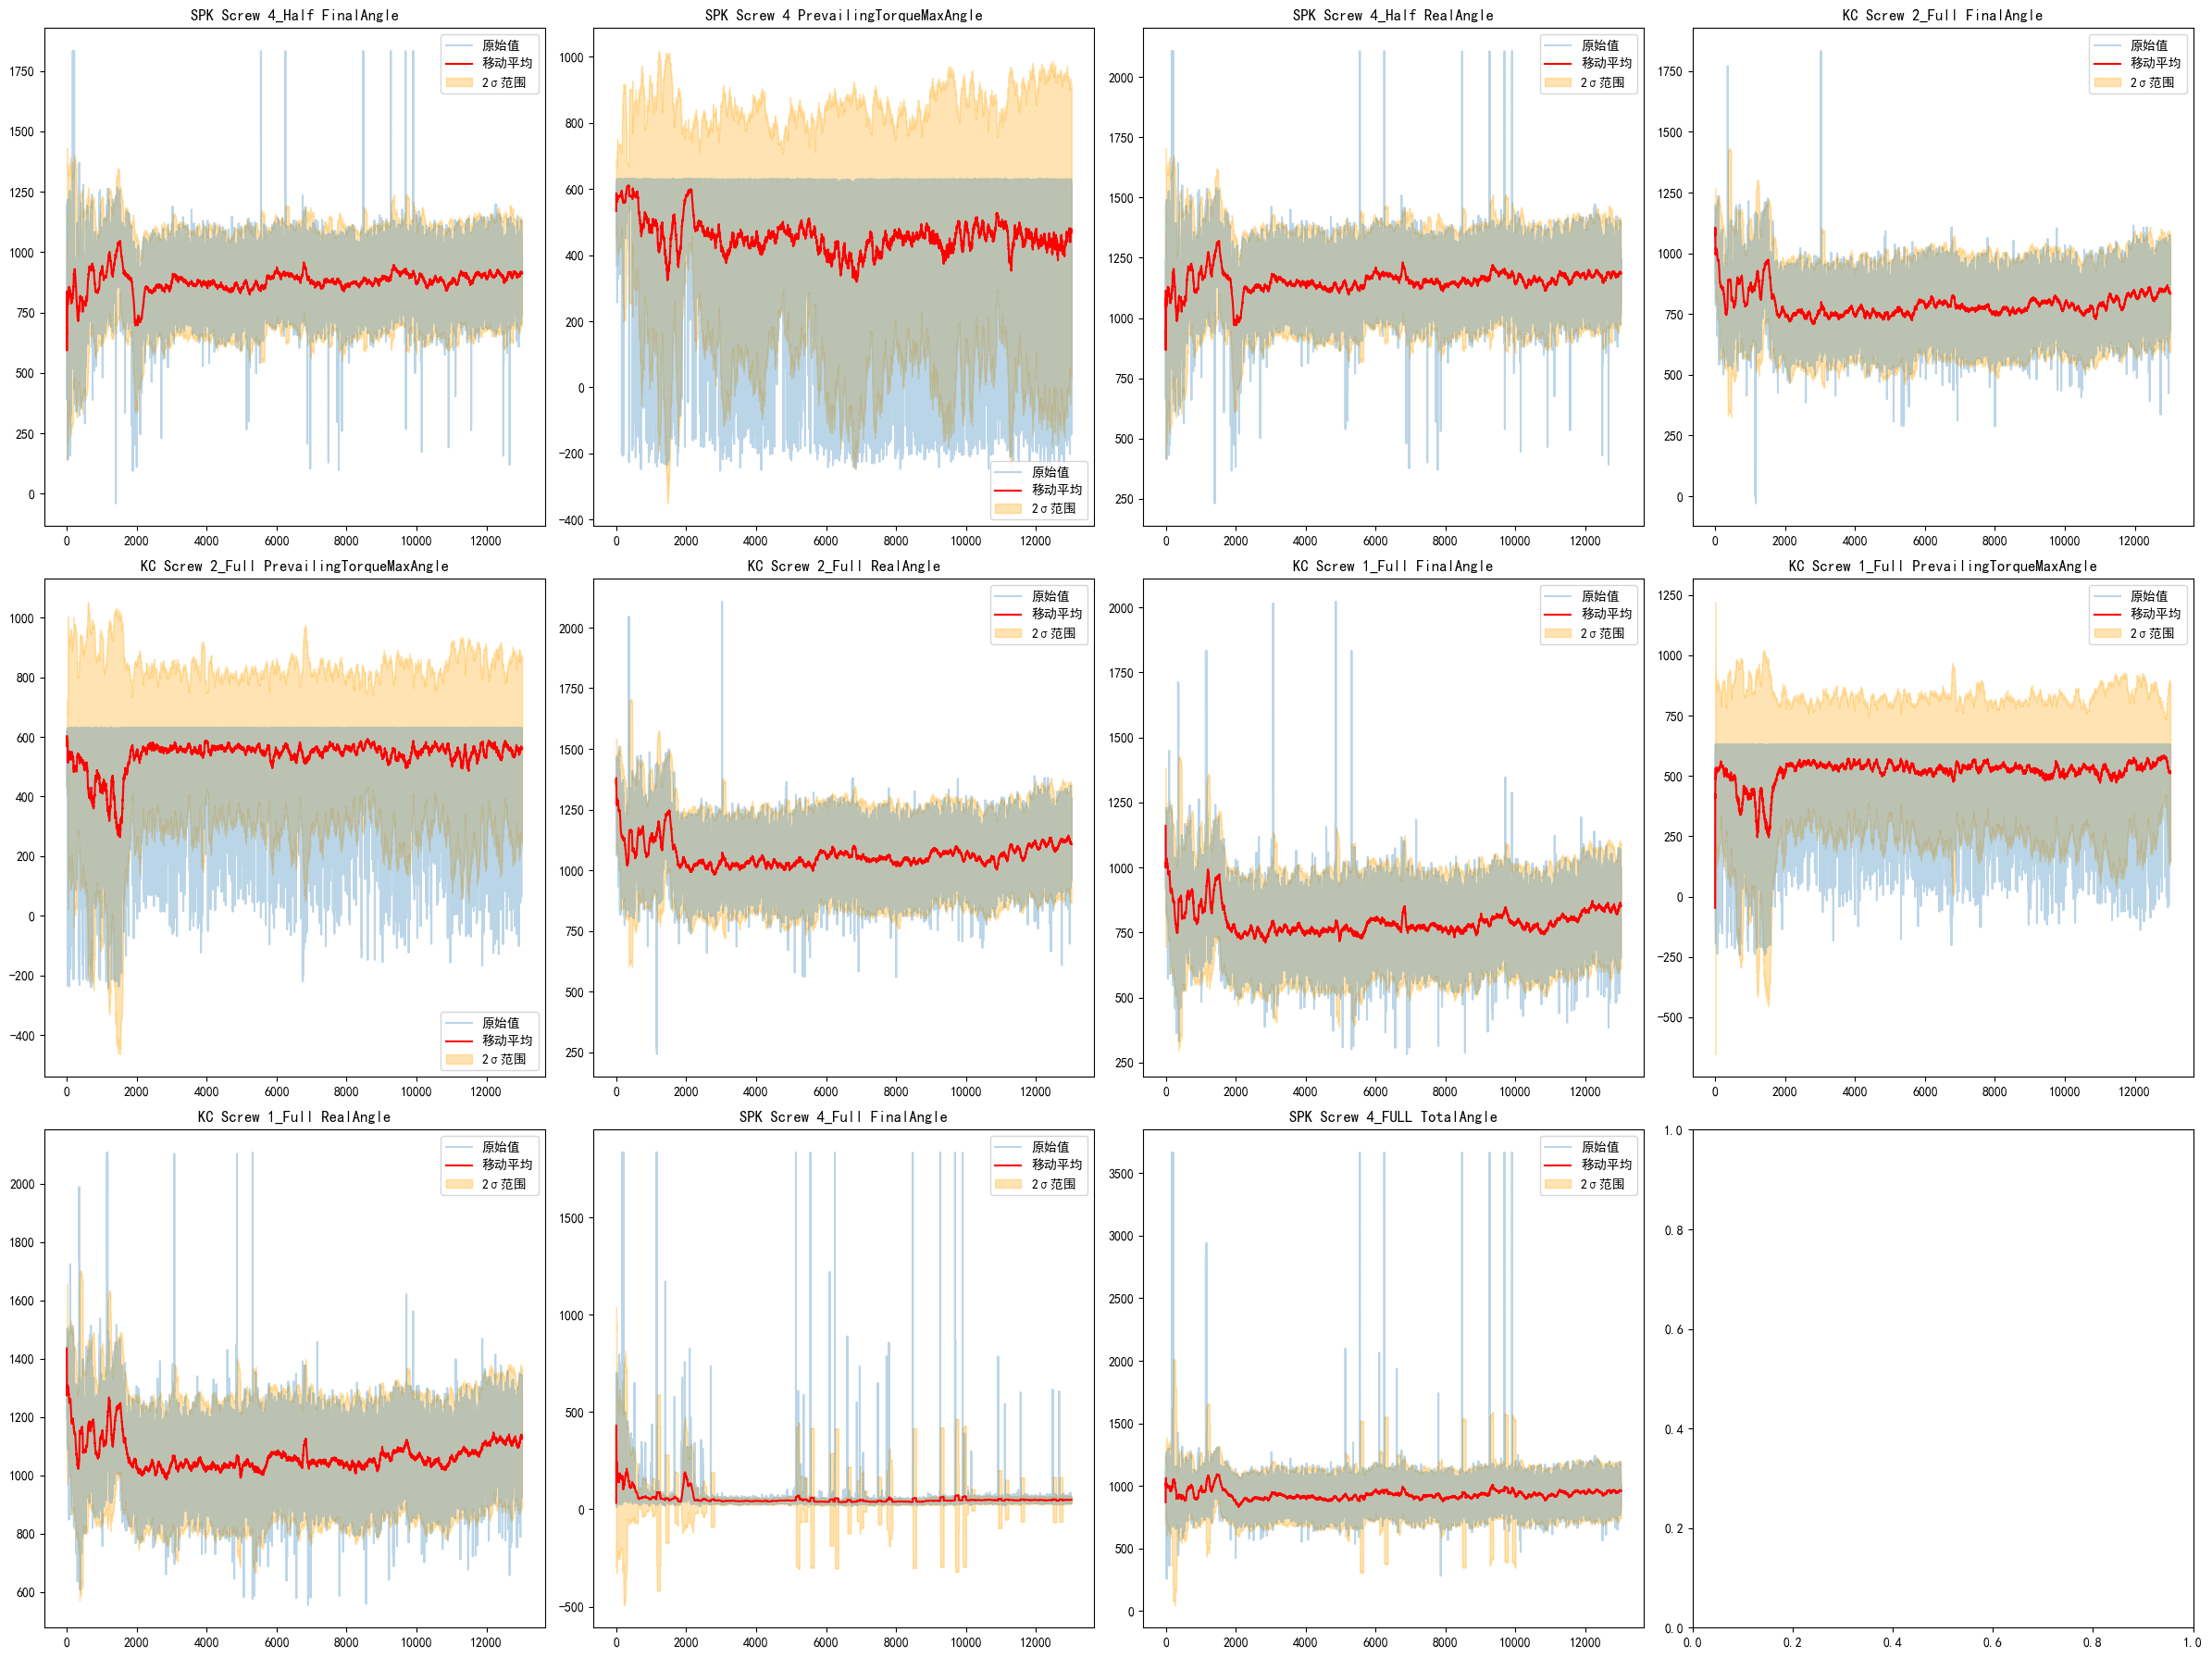

In [24]:
plotMov(df_plot, angle_cols)

## 2.2 重要性排序

In [49]:
df_imp = df_use.copy().iloc[:, 18:43]

result_cols = ['4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult']

cols1 = [col for col in df_imp.columns if '1' in col]
cols2 = [col for col in df_imp.columns if '2' in col]
cols4_half = [col for col in df_imp.columns if '4' in col and 'full' not in col.lower()]
cols4_full = [col for col in df_imp.columns if '4' in col and 'full' in col.lower()]

In [61]:
# 数据预处理函数
def preprocess_data(df, col, cols):
    # 复制数据避免修改原始数据
    df = df.copy()
    # 创建总体成功/成功的标签
    df['overall_result'] = 1  # 默认为成功
    df.loc[(df[col] == 'NG'), 'overall_result'] = 0
    df.loc[(df[col] == 'Toss'), 'overall_result'] = 2
    # df.loc[(df[col] == 'NAN'), 'overall_result'] = 3

    return df[cols + ['overall_result']]

In [66]:
# 6. 特征重要性分析(如果有足够的数据)
def feature_importance_analysis(df, title):
    """分析各特征对成功的影响程度"""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    X = df.drop(columns=['overall_result'])
    y = df['overall_result']
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # 标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 训练随机森林模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 获取特征重要性
    importance = model.feature_importances_
    feature_names = X.columns

    # 组合成DataFrame并按重要性降序排序
    df = pd.DataFrame({'feature': feature_names, 'importance': importance})
    df_sorted = df.sort_values(by='importance', ascending=False)  # 关键排序步骤

    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 4))
    sns.barplot(x='importance', y='feature', data=df_sorted)
    plt.tight_layout()
    plt.title(title)
    plt.show()
    
    print("\n特征重要性:")
    print(df_sorted.to_string(index=False))

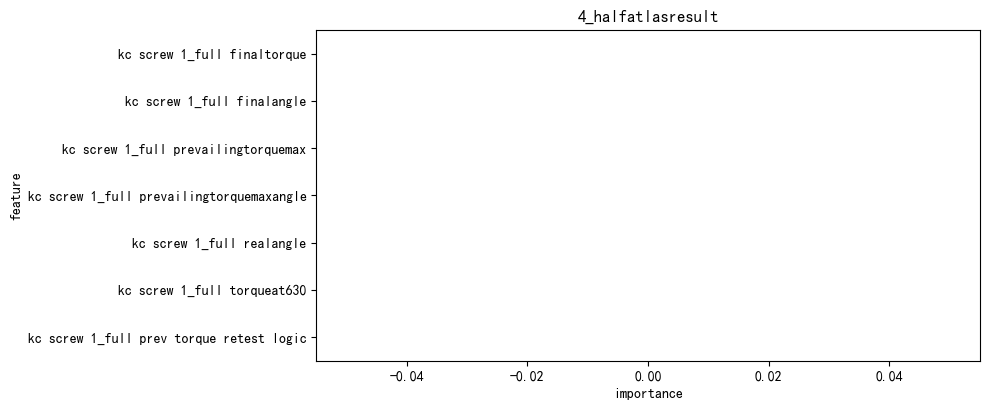


特征重要性:
                                 feature  importance
             kc screw 1_full finaltorque         0.0
              kc screw 1_full finalangle         0.0
     kc screw 1_full prevailingtorquemax         0.0
kc screw 1_full prevailingtorquemaxangle         0.0
               kc screw 1_full realangle         0.0
             kc screw 1_full torqueat630         0.0
kc screw 1_full prev torque retest logic         0.0


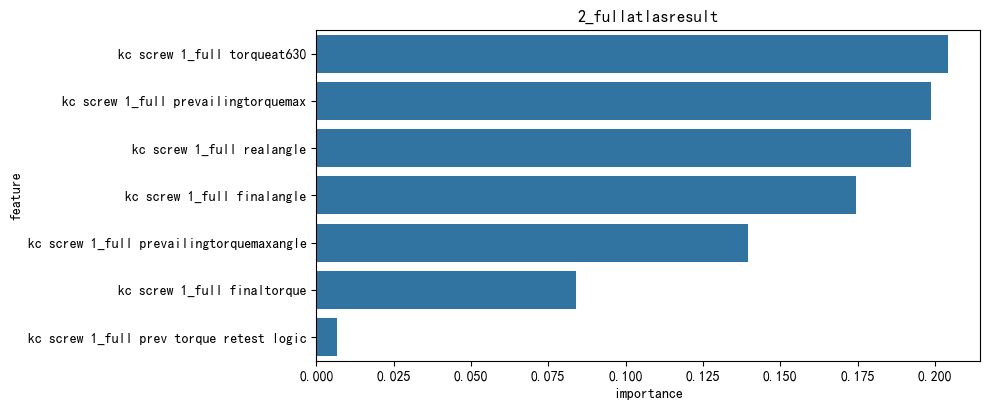


特征重要性:
                                 feature  importance
             kc screw 1_full torqueat630    0.204319
     kc screw 1_full prevailingtorquemax    0.198828
               kc screw 1_full realangle    0.192210
              kc screw 1_full finalangle    0.174590
kc screw 1_full prevailingtorquemaxangle    0.139385
             kc screw 1_full finaltorque    0.083987
kc screw 1_full prev torque retest logic    0.006682


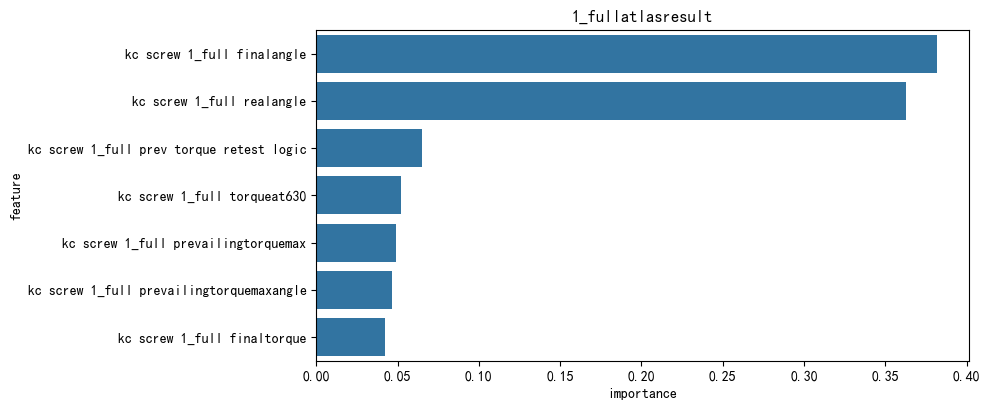


特征重要性:
                                 feature  importance
              kc screw 1_full finalangle    0.382067
               kc screw 1_full realangle    0.362889
kc screw 1_full prev torque retest logic    0.065166
             kc screw 1_full torqueat630    0.052011
     kc screw 1_full prevailingtorquemax    0.049287
kc screw 1_full prevailingtorquemaxangle    0.046418
             kc screw 1_full finaltorque    0.042162


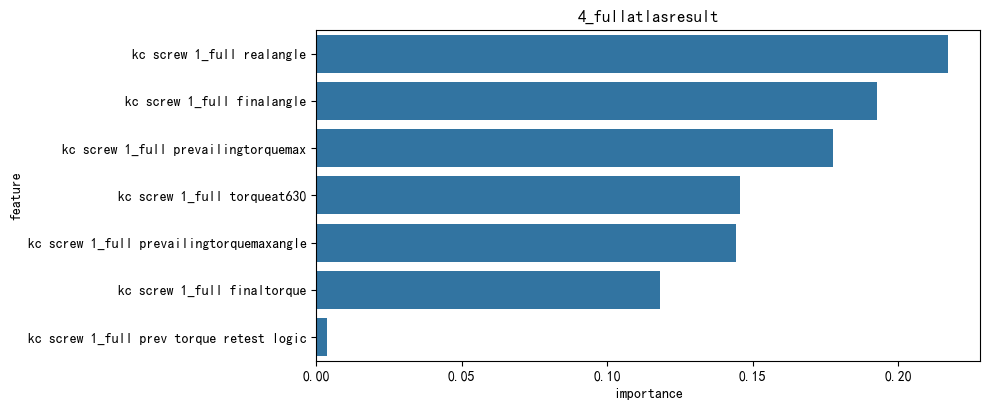


特征重要性:
                                 feature  importance
               kc screw 1_full realangle    0.217351
              kc screw 1_full finalangle    0.192833
     kc screw 1_full prevailingtorquemax    0.177817
             kc screw 1_full torqueat630    0.145782
kc screw 1_full prevailingtorquemaxangle    0.144249
             kc screw 1_full finaltorque    0.118240
kc screw 1_full prev torque retest logic    0.003728


In [68]:
# name = '1_fullatlasresult'
# 预处理数据
for name in result_cols:
    df_result = preprocess_data(df_use, name, cols1)
    feature_importance_analysis(df_result, name)